# Personalized PageRank Graph Visualization

In [1]:
from matplotlib.animation import FuncAnimation
import gzip
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import shutil
import urllib.request

### Dataset Filenames

In [2]:
filenames = [
    # 'higgs-social_network.edgelist',
    # 'higgs-retweet_network.edgelist',
    'higgs-reply_network.edgelist',
    # 'higgs-mention_network.edgelist'
]

### Retrieve Dataset if Not Present in Directory

In [3]:
ROOT = 'https://snap.stanford.edu/data'

for filename in filenames:
    if not os.path.exists(filename):
        # Download .gz file
        urllib.request.urlretrieve(f'{ROOT}/{filename}.gz', f'{filename}.gz')

        # Extract .edgelist file from .gz file
        with gzip.open(f'{filename}.gz') as gzip_file:
            with open(filename, 'wb') as edgelist_file:
                shutil.copyfileobj(gzip_file, edgelist_file)
        
        # Remove .gz file
        os.remove(f'{filename}.gz')

### Personalized PageRank Algorithm

In [4]:
def personalized_pagerank(G, input_node, beta=0.85, tolerance=1e-6):
    N = len(G.nodes)
    
    # Assign numeric node_id to each node
    node_ids = dict(zip(G.nodes, np.arange(0, N)))
    nx.set_node_attributes(G, node_ids, 'node_id')

    # Generate personalization vector based on input node
    personalization_vec = np.zeros(N)
    personalization_vec[G.nodes[input_node]['node_id']] = 1

    # Transition matrix
    tsn_mx = np.zeros(shape=(N, N))
    for edge in G.edges():
        u = G.nodes[edge[0]]['node_id']
        v = G.nodes[edge[1]]['node_id']
        tsn_mx[v, u] = 1 / np.where(G.out_degree(edge[0]) > 0, G.out_degree(edge[0]), 1)

    # Handling dangling nodes
    row_sum = tsn_mx.sum(axis=0)
    dangling_weights = personalization_vec
    is_dangling = np.where(row_sum == 0)[0]

    # PageRank vector, prev_pr to keep track of previous value to test convergence
    pr = np.ones(N)
    prev_pr = np.zeros(N)

    yield G.nodes, pr, 0
    yield G.nodes, pr, 0

    # Iterate PageRank calculation until convergence
    i = 0
    while ~np.all(np.abs(pr - prev_pr) < tolerance):
        prev_pr = pr
        pr = beta * (np.matmul(tsn_mx, pr) + sum(pr[is_dangling]) * dangling_weights) + (1 - beta) * personalization_vec
        pr /= np.linalg.norm(pr, ord=1)
        i += 1

        yield G.nodes, pr, i

    # Set PageRank values as node attributes
    pagerank = dict(zip(G.nodes, pr))
    nx.set_node_attributes(G, pagerank, 'pagerank')

    # Print top 20 recommendations
    print(sorted(G.nodes, key=lambda n: G.nodes[n]['pagerank'], reverse=True)[:20])

    return pr

### Twitter Dataset

In [5]:
# Retrieve edges from dataset
G = nx.DiGraph()

for filename in filenames:
    with open(filename, 'r') as f:
        G.add_edges_from([tuple(edge.split(' ')[:2]) for edge in f.readlines()])

personalized_pagerank(G, '20120')

<generator object personalized_pagerank at 0x7fefd181bc30>

### Test on Smaller Graph

In [6]:
edges = [
    (1, 2),
    (2, 1),
    (1, 3),
    (3, 1),
    (2, 4),
    (3, 4),
    (4, 3),
    (1, 4),
    (4, 1),
    (2, 3),
    (3, 2),
    (4, 5)
]

# Compare PageRank values with NetworkX
G = nx.DiGraph()
G.add_edges_from(edges)
print(personalized_pagerank(G, 3))
nx.pagerank(G, alpha=0.85, personalization={1: 0, 2: 0, 3: 1, 4: 0, 5: 0})

<generator object personalized_pagerank at 0x7fefd18985f0>


{1: 0.20778175890379336,
 2: 0.16190771686152594,
 3: 0.3636574307154471,
 4: 0.20778175890379336,
 5: 0.05887133461543994}

### Visualize Graph

In [7]:
def update(r):
    nodes, pr, i = r
    plt_nodes = nx.draw_networkx_nodes(
        G,
        pos=nx.kamada_kawai_layout(G),
        ax=ax,
        nodelist=nodes,
        node_color=pr,
        alpha=1,
        node_size=700,
        cmap=plt.cm.Blues,
        vmin=0,
        vmax=0.2
    )
    ax.axis('off')
    ax.set_title(f'Iteration {i}')
    nx.draw_networkx_edges(G, nx.kamada_kawai_layout(G), arrows=True)
    nx.draw_networkx_labels(G, nx.kamada_kawai_layout(G), font_size=14)
    
    return [plt_nodes, ]

[3, 1, 4, 2, 5]


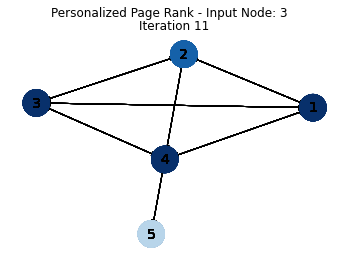

In [8]:
input_node = 3

f, ax = plt.subplots()
ani = FuncAnimation(
    f,
    update,
    frames=personalized_pagerank(G, input_node),
    interval=500,
    blit=True
)
f.suptitle(f'Personalized Page Rank - Input Node: {input_node}')
ani.save('personalized_pagerank.gif')

### References:

https://github.com/networkx/networkx/blob/main/networkx/algorithms/link_analysis/pagerank_alg.py
<br>
https://towardsdatascience.com/pagerank-algorithm-fully-explained-dc794184b4af
<br>
https://www.youtube.com/watch?v=RVIr8Y5isek
<br>
Visualization:
https://stellasia.github.io/blog/2020-03-07-page-rank-animation-with-networkx-numpy-and-matplotlib/